In [1]:
# AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [3]:
#mirrored_strategy = tf.distribute.MirroredStrategy(["/GPU:0","/GPU:1", "/GPU:2"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())

In [4]:
n_kernel=100
l2Regularizer=1e-09
kernel_size1 = 5
kernel_size2 = 5
#kernel_size3 = 5
n_grid = 128
strides = 1
input_size = 100
lr=0.001

In [5]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [6]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [7]:
aa = aa.reshape((133, 16, 1, 1))

In [8]:
os.chdir('D:\\AeroCNN2Inputs')

In [9]:
origin = "D:\\rotatedInterpolation_pow2\\n_grid128\\velocityMagnitudeField"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [10]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [11]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "alpha"+ str(int(alpha[j])) + "_velocityMagnitudeInterpolated.csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [79]:
image_np = image_df.iloc[:, :].values
np.savetxt('D:\\InputImages.csv', image_np, delimiter=",")

In [13]:
image = image_np.reshape((133, 16, n_grid+1, n_grid+1))

In [14]:
image = 1-image/100

In [15]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [16]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [78]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))
np.savetxt('Coefficients.csv', y, delimiter=",")

In [18]:
y = y.reshape((133, 16, 2, 1))

In [19]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [20]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [21]:
geometry.shape

(2128, 1)

In [22]:
geometry = geometry.reshape((133, 16, 1))

In [23]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(image, aa, geometry, y, test_size=0.05, random_state=1)

In [24]:
tf.keras.backend.set_image_data_format('channels_last')

In [25]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [26]:
#with mirrored_strategy.scope():
input_image = tf.keras.Input(shape=(n_grid+1, n_grid+1,1))
#reshape0 = tf.keras.layers.Reshape(())

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer1')(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernel*2, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer2')(x_)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernel*4, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer3')(x_)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernel*8, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer4')(x_)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)

reshape1 = tf.keras.layers.Flatten()(x_)

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(reshape1)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_)
output_image = tf.keras.layers.Reshape((2, 1))(output_data)
# CNN autoencoder
model = tf.keras.Model(input_image, output_image)

In [27]:
#with mirrored_strategy.scope():
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 129, 129, 1)]     0         
                                                                 
 Conv2DLayer1 (Conv2D)       (None, 129, 129, 100)     2600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 100)      0         
 )                                                               
                                                                 
 Conv2DLayer2 (Conv2D)       (None, 64, 64, 200)       500200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 200)      0         
 2D)                                                             
                                                                 
 Conv2DLayer3 (Conv2D)       (None, 32, 32, 400)       200040

In [28]:
#with mirrored_strategy.scope():
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [29]:
#with mirrored_strategy.scope():
start = datetime.datetime.now()
history = model.fit(x_train, y_train, epochs=5000, shuffle=True,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100,
                                                                restore_best_weights=True)])
end = datetime.datetime.now()

Epoch 1/5000
63/63 [==============================] - 6s 33ms/step - loss: 10.0283 - rmse: 3.1667
Epoch 2/5000
63/63 [==============================] - 2s 32ms/step - loss: 0.2074 - rmse: 0.4554
Epoch 3/5000
63/63 [==============================] - 2s 32ms/step - loss: 0.2037 - rmse: 0.4513
Epoch 4/5000
63/63 [==============================] - 2s 31ms/step - loss: 0.2048 - rmse: 0.4526
Epoch 5/5000
63/63 [==============================] - 2s 31ms/step - loss: 0.2040 - rmse: 0.4516
Epoch 6/5000
63/63 [==============================] - 2s 31ms/step - loss: 0.2050 - rmse: 0.4528
Epoch 7/5000
63/63 [==============================] - 2s 32ms/step - loss: 0.2024 - rmse: 0.4498
Epoch 8/5000
63/63 [==============================] - 2s 32ms/step - loss: 0.2016 - rmse: 0.4490
Epoch 9/5000
63/63 [==============================] - 2s 31ms/step - loss: 0.2016 - rmse: 0.4490
Epoch 10/5000
63/63 [==============================] - 2s 31ms/step - loss: 0.2018 - rmse: 0.4492
Epoch 11/5000
63/63 [=======

63/63 [==============================] - 2s 31ms/step - loss: 0.2005 - rmse: 0.4477
Epoch 85/5000
63/63 [==============================] - 2s 31ms/step - loss: 0.2005 - rmse: 0.4478
Epoch 86/5000
63/63 [==============================] - 2s 31ms/step - loss: 0.2005 - rmse: 0.4478
Epoch 87/5000
63/63 [==============================] - 2s 31ms/step - loss: 0.2004 - rmse: 0.4476
Epoch 88/5000
63/63 [==============================] - 2s 31ms/step - loss: 0.2003 - rmse: 0.4476
Epoch 89/5000
63/63 [==============================] - 2s 31ms/step - loss: 0.2004 - rmse: 0.4476
Epoch 90/5000
63/63 [==============================] - 2s 31ms/step - loss: 0.2003 - rmse: 0.4476
Epoch 91/5000
63/63 [==============================] - 2s 31ms/step - loss: 0.2006 - rmse: 0.4479
Epoch 92/5000
63/63 [==============================] - 2s 31ms/step - loss: 0.2005 - rmse: 0.4477
Epoch 93/5000
63/63 [==============================] - 2s 31ms/step - loss: 0.2004 - rmse: 0.4476
Epoch 94/5000
63/63 [=============

In [30]:
time = end - start
print("Training time:", time)

Training time: 0:05:06.093907


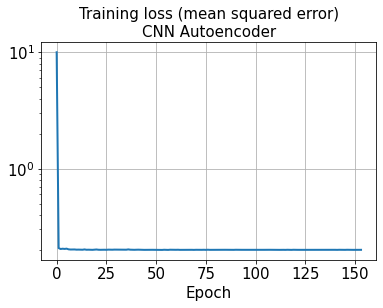

In [31]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nCNN Autoencoder', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

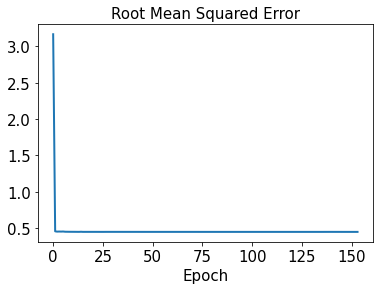

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

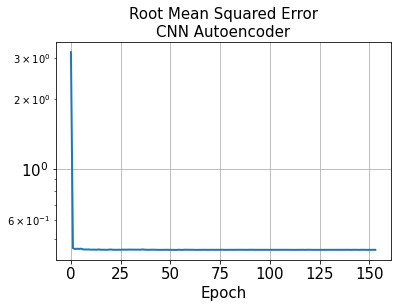

In [33]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nCNN Autoencoder', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

In [34]:
#with mirrored_strategy.scope():
test_results = model.evaluate(x_train)

63/63 [==============================] - 0s 2ms/step - loss: 1.8543e-06 - rmse: 0.0000e+00


In [35]:
#with mirrored_strategy.scope():
decoded_train = model.predict(x_train)

63/63 [==============================] - 1s 10ms/step


In [36]:
#with mirrored_strategy.scope():
decoded_test = model.predict(x_test)

4/4 [==============================] - 0s 77ms/step


In [37]:
error_train_abs = np.abs(decoded_train - y_train)

In [38]:
error_test_abs = np.abs(decoded_test - y_test)

In [39]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [40]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [41]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [42]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [43]:
os.chdir("D:\\TrainedModels\\20221024")
model.save('CNN_Autoencoder_ClCd_nGrid128_200kernel_2by2MaxPooling_1CNNlayer_testSize0.05.h5',
           overwrite=True, include_optimizer=True, save_format='h5')

In [44]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.8500070311126637


In [45]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.8400062211669315


In [46]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.8516127266857358


In [47]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.8067213499398995


In [48]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.841342055204369


In [49]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.8037731971130944


In [50]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[1.6394054115185157, 1.6551782659249499, 1.71670381236258, 2.002519382604852, 3.2916381118214826, 5.590338102223334, 0.4452510154550088, 0.26632795618963967, 0.4580033934410173, 0.5389144080603568, 0.2991881501331675, 0.4015531885168977, 0.43451760760125363, 0.46372810201079184, 0.6337006747989136, 0.7358088388092535, 1.508161149390302, 1.5283414204100445, 1.6699050236329986, 2.0472395878352825, 3.530868017971739, 4.745367863292919, 0.4328411752761128, 0.2686744485252186, 0.45834500108689097, 0.5277352600584267, 0.48033669262496637, 0.38214221828019, 0.3920297994642283, 0.5905391153422987, 0.6596632566183753, 0.6742205957164167, 1.685584862646069, 1.6194241301116117, 1.734856104191729, 2.316054121148029, 8.032529183200007, 1.0891916117290137, 0.19646030215259866, 0.43508590198735736, 0.5732310922517229, 0.6519446217929623, 0.6990844457730906, 0.7244971821871955, 0.5153299682402545, 0.6695465854263559, 0.7080147861639747, 0.7074929395999133, 1.6175424543892898, 1.6070293292053695, 1.695

In [51]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[1.6552530889043977, 1.6905319942873291, 1.7251014881473343, 2.0583504631740537, 3.5508091511486573, 4.420283920787634, 0.3963245224470171, 0.26394449173380724, 0.4255745303363055, 0.4827452203462768, 0.32714241603257815, 0.40025553889892507, 0.46065848306732154, 0.4803395455564698, 0.648934165036119, 0.6242632117834075, 1.4650681638348109, 1.5989160188188172, 1.8653199438418453, 2.639543473840747, 18.03571055809058, 0.9307093577116511, 0.19489213205344802, 0.4242911281934861, 0.5622951369914242, 0.6399206618646587, 0.6848468957112954, 0.7060657421976881, 0.7094845354486917, 0.6653968248845548, 0.5886451496739198, 0.6436738872485875, 1.6846698869368706, 1.6175140525984393, 1.726496738380939, 2.0427259789496373, 3.490106721725418, 4.600289109888925, 0.413354592340663, 0.26693188898549436, 0.4500621854376861, 0.5191314079059884, 0.2908859110160048, 0.3861712581134249, 0.5102860959427413, 0.6752634786532619, 0.6705531011284767, 0.7369086196378363, 1.6619635214651098, 1.5818632768993182, 1

In [52]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[1.6810140461504757, 1.6795631321286353, 1.7198717696839614, 1.9962855492017093, 3.2751891481884443, 5.6051630998879345, 0.3632274811162547, 0.22436069641983117, 0.4476997067508354, 0.535925930118395, 0.2963971783361679, 0.4006179390967912, 0.4252856689534953, 0.4452984427064543, 0.6161945787169388, 0.723567610075645, 1.5409742920153915, 1.527546158548223, 1.6667298794332572, 2.040196368232753, 3.5158787530793556, 4.734984436610565, 0.35170964651246545, 0.22869723328031108, 0.448499042684701, 0.5243199505381693, 0.48268406538523173, 0.3804726910858903, 0.37807331691791046, 0.5768873269992651, 0.6463980608986722, 0.6483537697800508, 1.7287064847298255, 1.6352030212214732, 1.732167994458433, 2.308073188698037, 8.26921195281239, 1.0249400021501942, 0.10619553245014525, 0.4224947981552686, 0.5684152751496274, 0.6495630036518122, 0.6978731062657307, 0.7241225680467026, 0.5124149329306928, 0.6616689578355986, 0.6933893339627173, 0.6928498088614432, 1.6507620899761675, 1.623119179545824, 1.69

In [53]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.33266725861694985, 0.10691196514055845, 1.0839102665156197, 4.065342932106641, 5.082391026790622, 5.319810917498246, 5.088897414517349, 4.460723955319544, 3.496311732737745, 1.3994524373123705, 0.4825735442658813, 0.41829568093018504, 0.537337535010352, 0.6118635295439301, 0.7566250827572156, 0.8249586008944628, 0.4402544657002993, 1.9532688389498514, 3.4692332132244332, 4.369459410041076, 4.856411510908998, 4.958058022707384, 4.74928072494121, 4.192506667123731, 3.218035964748348, 1.4696452705584133, 0.41865020831885613, 0.41040544607623036, 0.5249027294334385, 0.7059069040917804, 0.7644900221474316, 0.8079521297484473, 0.2840753598713509, 0.029745386937398793, 2.8152020793832366, 3.9572913269290684, 4.555222222206151, 4.701897808914482, 4.429775679988367, 3.9480257830158942, 3.323896291736394, 2.611524003033535, 1.8446443766219092, 1.0529111833853655, 0.5595176178365141, 0.7487525582370599, 0.8094029997688937, 0.8090284390176776, 0.2866381747739604, 0.00338931943763797, 1.15109633

In [54]:
np.sqrt(np.sum((decoded_train[:,1,:][36] - y_train[:,1,:][36])**2) / np.sum(y_train[:,1,:][36]**2))

4.555222222206151

In [55]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[1.696525009872975, 1.7142723123727617, 1.7276013852318923, 2.0527880710443402, 3.537725480656019, 4.38507253888271, 0.30963009146267567, 0.22296559365817398, 0.41607324542116514, 0.4818206550585129, 0.331235775794756, 0.3991033892801531, 0.4523835767171649, 0.46317606128074784, 0.6343634381930223, 0.5991566251715138, 1.4640622413809072, 1.5965894346975622, 1.8606162105680681, 2.6295809089790927, 25.588666992194852, 0.867389413271522, 0.1062344593966244, 0.41117476740138176, 0.5572951807970403, 0.6374445167448207, 0.6835849483694345, 0.7056870603950243, 0.7103548352959067, 0.6682463925299944, 0.5903310499148147, 0.6123230650547672, 1.729196991091499, 1.6374062579096926, 1.7273165939640684, 2.03624868869106, 3.4738584800157053, 4.572172274116144, 0.3284343110644426, 0.22531091631025463, 0.43963118994649697, 0.5160044983421403, 0.2890477179398171, 0.38613454524779306, 0.5049520898291954, 0.6688427613982666, 0.6582957887201447, 0.722477964506332, 1.6907317755460307, 1.5870086867994386, 1.

In [56]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.30904395573499893, 0.03658147836942398, 1.2008213944761668, 3.530069130910054, 4.636268503086796, 5.261270538976827, 5.0651013886992216, 4.07345304684954, 2.2041604065378317, 0.6371539100006413, 0.14953724183265038, 0.42052558414695995, 0.5557080034563393, 0.6219084315383987, 0.760002935519342, 0.7679240973931607, 2.2103280584305804, 3.01761591960536, 3.681412651180143, 4.133636897041017, 4.377491035478014, 4.400184680898982, 4.170962725109682, 3.7317670745947225, 3.119799615813204, 2.4322441121864626, 1.7134688933831246, 0.9854621266738053, 0.2448841262970732, 0.24424939542545301, 0.5470955133004113, 0.7939594421245544, 0.29624361700854246, 0.0818474123309335, 1.5228240026163802, 4.037460732835597, 5.019331032494709, 5.238534347529105, 5.077904357226623, 4.429211325412461, 3.2558975102961596, 1.2995353126915141, 0.4070987560046773, 0.38688198425092335, 0.5798079136602584, 0.7451572571286031, 0.7700316994842902, 0.8322100976611133, 0.16548876301766097, 0.5478391327317144, 1.98028078

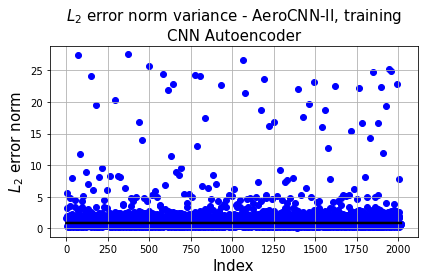

In [57]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, training\nCNN Autoencoder', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

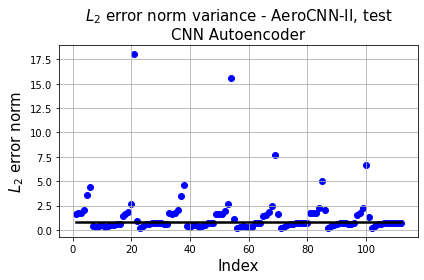

In [58]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, test\nCNN Autoencoder', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

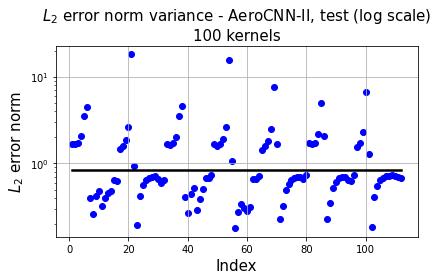

In [59]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, test (log scale)\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

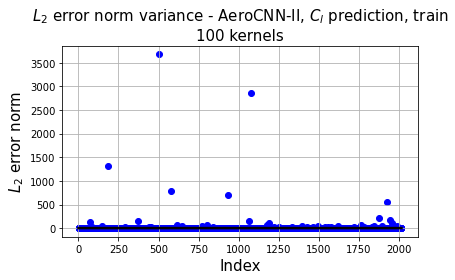

In [60]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

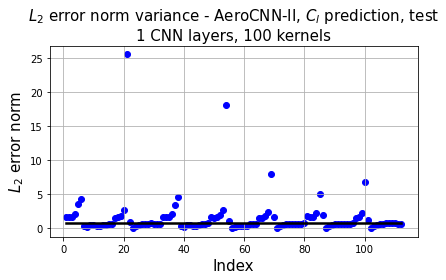

In [61]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

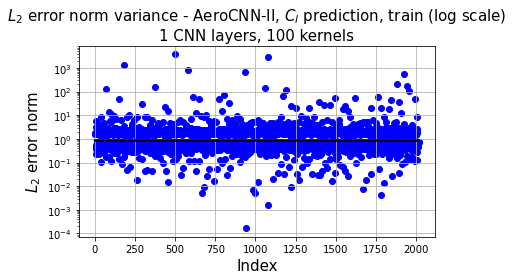

In [62]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train (log scale)\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

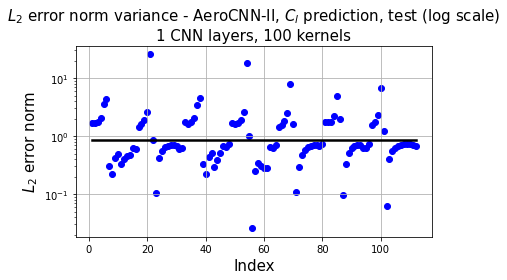

In [63]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test (log scale)\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

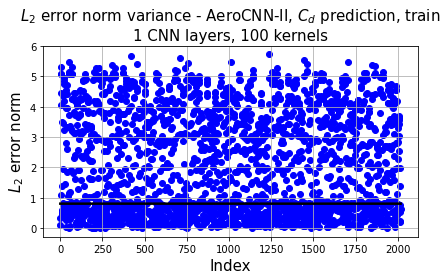

In [64]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

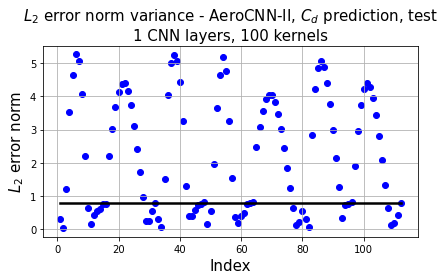

In [65]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

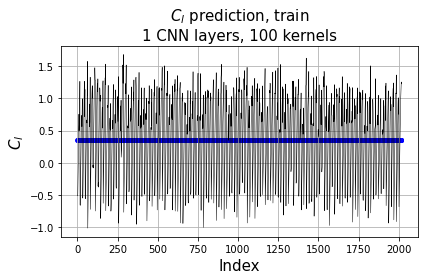

In [66]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

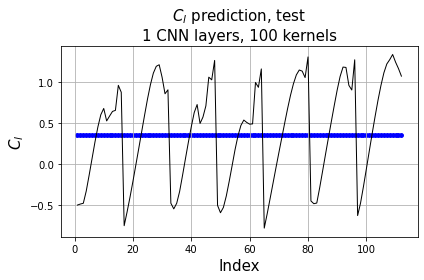

In [67]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

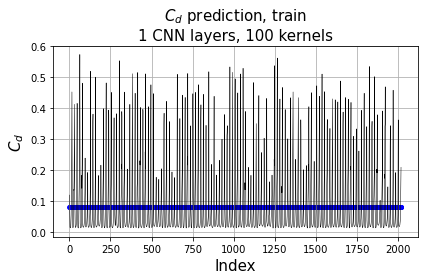

In [68]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

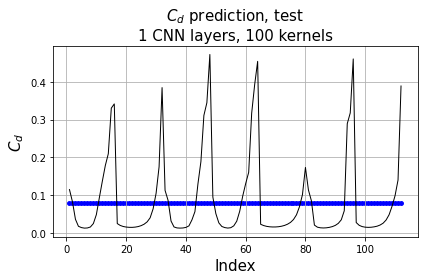

In [69]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

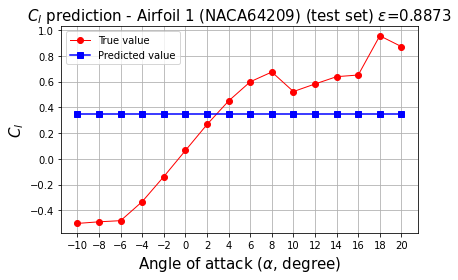

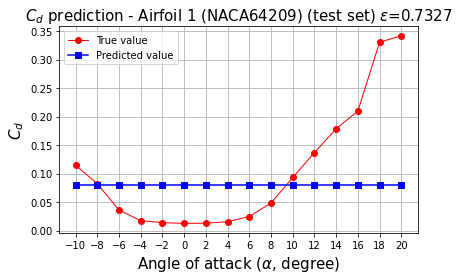

In [70]:
airfoiltest1_predict = decoded_test[16*0:16*1]

airfoiltest1_cl=y_test[16*0:16*1,0,:]
airfoiltest1_cd=y_test[16*0:16*1,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

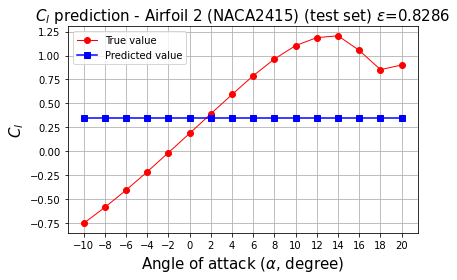

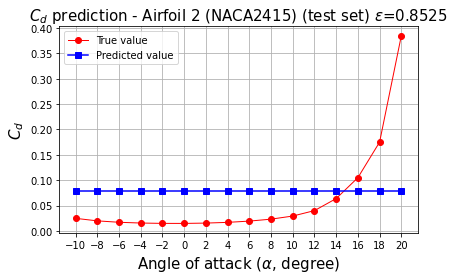

In [71]:
airfoiltest37_predict = decoded_test[16*1:16*2]

airfoiltest37_cl=y_test[16*1:16*2,0,:]
airfoiltest37_cd=y_test[16*1:16*2,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2) / np.sum(airfoiltest37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2) / np.sum(airfoiltest37_cd**2))

plt.plot(alpha, airfoiltest37_cl.reshape(16,), 'r', marker='o',lw=1)
plt.plot(alpha, airfoiltest37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

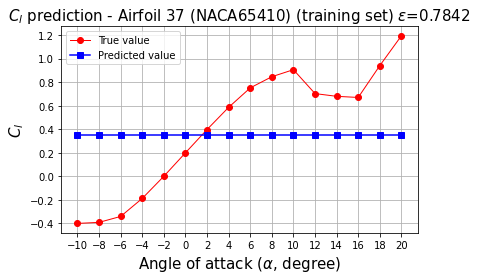

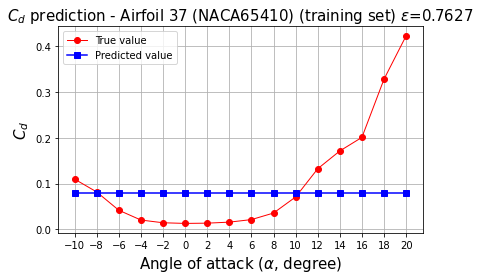

In [72]:
airfoiltrain37_predict = decoded_train[16*36:16*37]

airfoiltrain37_cl=y_train[16*36:16*37,0,:]
airfoiltrain37_cd=y_train[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain37_predict[:,0,:] - airfoiltrain37_cl)**2) / np.sum(airfoiltrain37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain37_predict[:,1,:] - airfoiltrain37_cd)**2) / np.sum(airfoiltrain37_cd**2))

plt.plot(alpha, airfoiltrain37_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

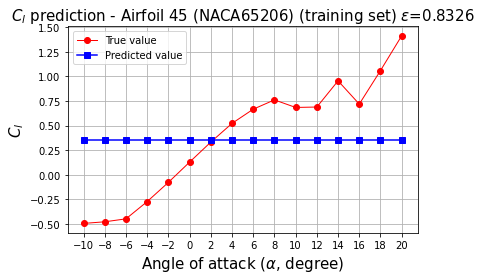

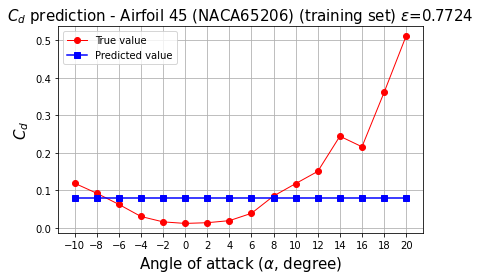

In [73]:
airfoiltrain45_predict = decoded_train[16*44:16*45]

airfoiltrain45_cl=y_train[16*44:16*45,0,:]
airfoiltrain45_cd=y_train[16*44:16*45,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain45_predict[:,0,:] - airfoiltrain45_cl)**2) / np.sum(airfoiltrain45_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain45_predict[:,1,:] - airfoiltrain45_cd)**2) / np.sum(airfoiltrain45_cd**2))

plt.plot(alpha, airfoiltrain45_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCl),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain45_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCd),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

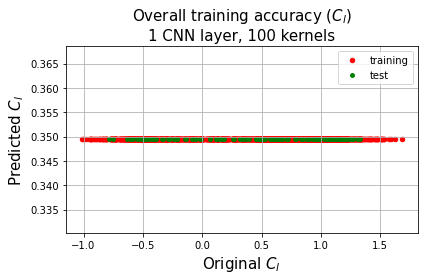

In [74]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)\n1 CNN layer, 100 kernels', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

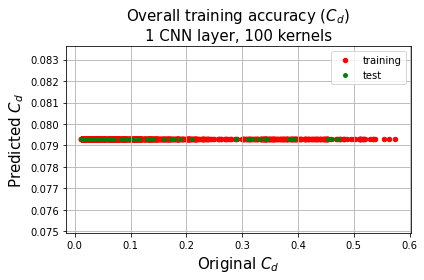

In [75]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)\n1 CNN layer, 100 kernels', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

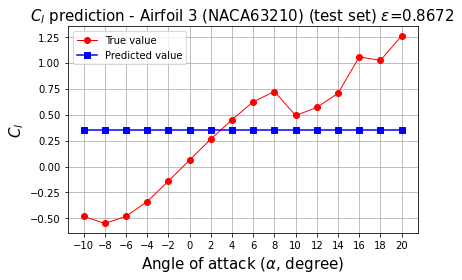

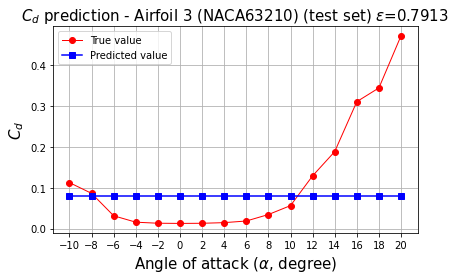

In [76]:
airfoiltest3_predict = decoded_test[16*2:16*3]

airfoiltest3_cl=y_test[16*2:16*3,0,:]
airfoiltest3_cd=y_test[16*2:16*3,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest3_predict[:,0,:] - airfoiltest3_cl)**2) / np.sum(airfoiltest3_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest3_predict[:,1,:] - airfoiltest3_cd)**2) / np.sum(airfoiltest3_cd**2))

plt.plot(alpha, airfoiltest3_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,0,:].reshape(16,), marker='s', c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest3_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,1,:].reshape(16,), marker='s',c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

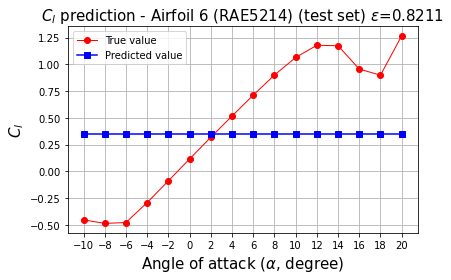

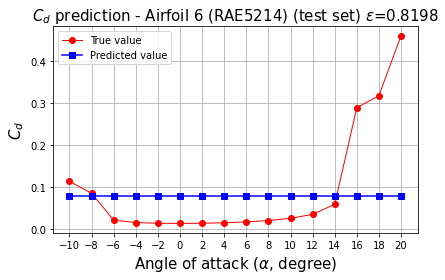

In [77]:
airfoiltest11_predict = decoded_test[16*5:16*6]

airfoiltest11_cl=y_test[16*5:16*6,0,:]
airfoiltest11_cd=y_test[16*5:16*6,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest11_predict[:,0,:] - airfoiltest11_cl)**2) / np.sum(airfoiltest11_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest11_predict[:,1,:] - airfoiltest11_cd)**2) / np.sum(airfoiltest11_cd**2))

plt.plot(alpha, airfoiltest11_cl.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest11_cd.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()